In [24]:
# Import denpendecies
import requests
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Extracting data from Postgres using APIs

In [25]:
# Define a list of table names and their corresponding API endpoints
tables = {
            
        "Bureau" : 'http://127.0.0.1:5000/bureau',
        "Bureau_balance" : 'http://127.0.0.1:5000/bureau_balance',
        "Credit_card_balance" : 'http://127.0.0.1:5000/credit_card_balance',
        "Installments_payments" : 'http://127.0.0.1:5000/installments_payments',
        "POS_CASH_balance" : 'http://127.0.0.1:5000/pOS_CASH_balance',
        "Previous_application" : 'http://127.0.0.1:5000/previous_application',
        "Application_train" : 'http://127.0.0.1:5000/application_train'
}

# Dictionary to store DataFrames for each table
dataframes = {}

# Make API requests to get data from each table
for table_name, endpoint in tables.items():
    response = requests.get(endpoint)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Convert API response to a DataFrame and store it in the dictionary
        dataframes[table_name] = pd.DataFrame(response.json())
        print(f"Data for {table_name} fetched successfully.")
    else:
        print(f"Error: Unable to fetch data from {table_name}. Status code: {response.status_code}")

Data for Bureau fetched successfully.
Data for Bureau_balance fetched successfully.
Data for Credit_card_balance fetched successfully.
Data for Installments_payments fetched successfully.
Data for POS_CASH_balance fetched successfully.
Data for Previous_application fetched successfully.
Data for Application_train fetched successfully.


## Combining DataFrames

In [26]:
# Merge tables based on specified keys
merged_table = dataframes["Application_train"]

# Merge POS_CASH_balance, Installments_payments, Credit_card_balance based on SK_ID_PREV
for table_name in ["POS_CASH_balance", "Installments_payments", "Credit_card_balance", "Previous_application"]:
    if table_name in dataframes:
        # Specify suffixes to avoid duplicate column names
        merged_table = pd.merge(merged_table, dataframes[table_name], on='SK_ID_CURR', how='left', suffixes=('', f'_{table_name}'))

# Merge Bureau and Bureau_balance based on SK_ID_BUREAU
if "Bureau" in dataframes and "Bureau_balance" in dataframes:
    bureau_merged = pd.merge(dataframes["Bureau"], dataframes["Bureau_balance"], on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bureau_balance'))
    merged_table = pd.merge(merged_table, bureau_merged, on='SK_ID_CURR', how='left')

# Display the final merged table with unique columns
unique_columns = merged_table.columns.unique()
final_table = merged_table[unique_columns]

# Display the final table
final_table.head()

,AMT_ANNUITY_x,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,CREDIT_CURRENCY,CREDIT_DAY_OVERDUE,CREDIT_TYPE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_CREDIT_UPDATE,DAYS_ENDDATE_FACT,SK_ID_BUREAU,MONTHS_BALANCE_y,STATUS
0,13315.5,254700.0,225000.0,90000.0,0.0,0.0,7.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13315.5,254700.0,225000.0,90000.0,0.0,0.0,7.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29754.0,747000.0,747000.0,405000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29754.0,747000.0,747000.0,405000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29754.0,747000.0,747000.0,405000.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning & Encoding categorical variables

In [5]:
# Drop duplicate values
data_df = final_table.drop_duplicates()

In [6]:
# Fill na with (0)
data_df=data_df.fillna(0)

In [7]:
# Changing CODE_GENDER to 0 and 1 to match model
data_df['CODE_GENDER'] = data_df['CODE_GENDER'].replace({'F': 0, 'M': 1})

In [8]:
# Changing FLAG_OWN_REALTY AND FLAG_OWN_CAR to 0 and 1 to match model
data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']] = data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']].replace({'Y': 1, 'N': 0}).astype(int)

## Assigning Values to X and y

In [9]:
# Selecting X features
X = data_df.drop(columns=['TARGET'], axis=1)

In [10]:
# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X).astype(int)

In [11]:
# select Target variable
y = data_df['TARGET'].values

## Machine learning model: Randon Forest Classifier

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance

scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities = model.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions = (positive_class_probabilities > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[47266     0]
 [ 1577  2277]]

Accuracy: 0.9691510172143974


In [16]:
report = classification_report(y_test, binary_predictions)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     47266
           1       1.00      0.59      0.74      3854

    accuracy                           0.97     51120
   macro avg       0.98      0.80      0.86     51120
weighted avg       0.97      0.97      0.97     51120



## Assigning risk levels

In [17]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels = pd.cut(positive_class_probabilities, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities, 'Risk Level': risk_levels})
result_df.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df = result_df.drop_duplicates()
result_df = result_df.reset_index(drop=True)
# Print the result DataFrame
print(result_df)

       SK_ID_CURR  Probability     Risk Level
0          100006         0.12  Very Low Risk
1          100008         0.10  Very Low Risk
2          100015         0.14  Very Low Risk
3          100016         0.03  Very Low Risk
4          100017         0.11  Very Low Risk
...           ...          ...            ...
36370      456239         0.03  Very Low Risk
36371      456241         0.12  Very Low Risk
36372      456242         0.11  Very Low Risk
36373      456243         0.15  Very Low Risk
36374      456244         0.02  Very Low Risk

[36375 rows x 3 columns]


## Top contributing features

In [18]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted = importances_sorted[:30]
sorted_df = pd.DataFrame(importances_sorted)
sorted_df[1]

0                           DAYS_BIRTH
1                      DAYS_ID_PUBLISH
2                    DAYS_REGISTRATION
3                        AMT_ANNUITY_x
4                           SK_ID_CURR
5               DAYS_LAST_PHONE_CHANGE
6                        DAYS_EMPLOYED
7                           AMT_CREDIT
8                     AMT_INCOME_TOTAL
9                      AMT_GOODS_PRICE
10             HOUR_APPR_PROCESS_START
11          AMT_REQ_CREDIT_BUREAU_YEAR
12    SK_ID_PREV_Installments_payments
13                         OWN_CAR_AGE
14            OBS_30_CNT_SOCIAL_CIRCLE
15            OBS_60_CNT_SOCIAL_CIRCLE
16                      AMT_INSTALMENT
17                  DAYS_ENTRY_PAYMENT
18                     DAYS_INSTALMENT
19      SK_ID_PREV_Credit_card_balance
20                         AMT_PAYMENT
21               NUM_INSTALMENT_NUMBER
22                          SK_ID_PREV
23                     CNT_FAM_MEMBERS
24                    MONTHS_BALANCE_x
25               CNT_INST

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

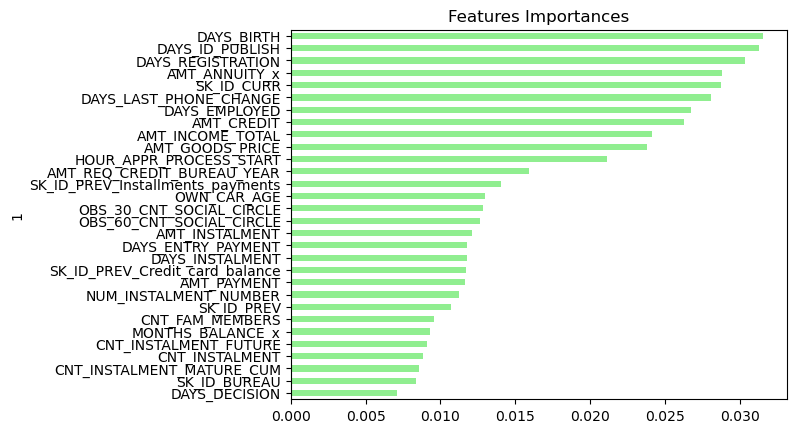

In [19]:
sorted_df.set_index(sorted_df[1], inplace=True)
sorted_df.drop(columns=1, inplace=True)
sorted_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = sorted_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

## Selecting top contributing features

In [20]:
X  = data_df[["DAYS_ID_PUBLISH",
                           "DAYS_BIRTH",
                      "DAYS_REGISTRATION",
                 "DAYS_LAST_PHONE_CHANGE",
                          "AMT_ANNUITY_x",
                             "SK_ID_CURR",
                             "AMT_CREDIT",
                          "DAYS_EMPLOYED",
                        "AMT_GOODS_PRICE",
                       "AMT_INCOME_TOTAL",
               "HOUR_APPR_PROCESS_START",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
                           "OWN_CAR_AGE",
              "OBS_30_CNT_SOCIAL_CIRCLE",
              "OBS_60_CNT_SOCIAL_CIRCLE",
                           "AMT_PAYMENT",
                    "DAYS_ENTRY_PAYMENT",
                        "AMT_INSTALMENT",
                       "DAYS_INSTALMENT",
                 "NUM_INSTALMENT_NUMBER",
                 "CNT_INSTALMENT_FUTURE",
                      "MONTHS_BALANCE_x",
                       "CNT_FAM_MEMBERS",
                        "CNT_INSTALMENT",
             "CNT_INSTALMENT_MATURE_CUM",
    "MONTHS_BALANCE_Credit_card_balance"]]

In [21]:
# Fillna (0) in the selective features
X_features = X.fillna(0)

In [22]:
# Selective target variable
y_features = data_df['TARGET']

## Machine learning model: Random Forest Classifier

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model_features = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[47266     0]
 [ 1518  2336]]

Accuracy: 0.9703051643192488


In [ ]:
report = classification_report(y_test, binary_predictions_features)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     45513
           1       1.00      0.60      0.75      3778

    accuracy                           0.97     49291
   macro avg       0.98      0.80      0.87     49291
weighted avg       0.97      0.97      0.97     49291



In [ ]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels_features = pd.cut(positive_class_probabilities_features, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df_features = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities_features, 'Risk Level': risk_levels_features})
result_df_features.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df_features = result_df_features.drop_duplicates()
result_df_features = result_df_features.reset_index(drop=True)
# Print the result DataFrame
print(result_df_features)

       SK_ID_CURR  Probability     Risk Level
0          100007         0.02  Very Low Risk
1          100007         0.06  Very Low Risk
2          100007         0.05  Very Low Risk
3          100010         0.04  Very Low Risk
4          100016         0.07  Very Low Risk
...           ...          ...            ...
33829      456244         0.00  Very Low Risk
33830      456247         0.13  Very Low Risk
33831      456247         0.16  Very Low Risk
33832      456248         0.07  Very Low Risk
33833      456251         0.30       Low Risk

[33834 rows x 3 columns]


In [ ]:
import joblib
joblib.dump(model_features, 'model_probability.joblib')

['model_probability.joblib']